In [39]:
# Let us first import all the necessary packages.
from __future__ import division, print_function
import torch
from torch.autograd import Variable
from torch_submod.graph_cuts import TotalVariation2dWeighted as tv2d
from matplotlib import pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm  
from pandas import DataFrame

# We will plot the images using the following function.
def plot(x):
    plt.figure(figsize=(5, 10))
    plt.imshow(x.numpy())

### Data creation

We will create first a simple image ``x``, and corrupt it with normal noise to get ``x_noisy``.

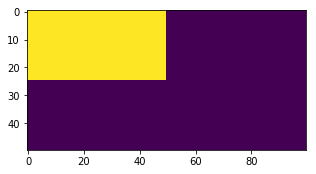

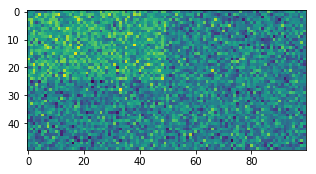

In [32]:
torch.manual_seed(0)  # To ensure reproducibility.
m, n = 50, 100  # The image dimensions.
std = 1e-1  # The standard deviation of noise.
x = torch.zeros((m, n))
x[:m//2, :n//2] += 1
x_noisy = x + torch.normal(torch.zeros(x.size()))

plot(x)
plot(x_noisy)

In [33]:
# We need to create variables from them.
x = Variable(x, requires_grad=False)
x_noisy = Variable(x_noisy, requires_grad=False)

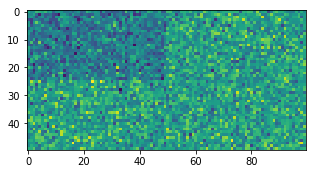

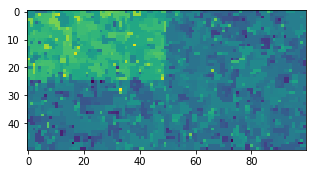

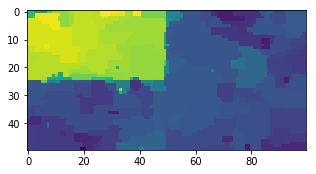

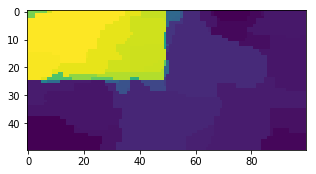

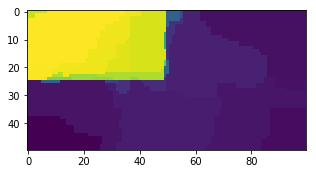

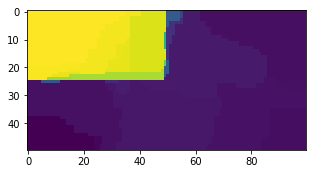

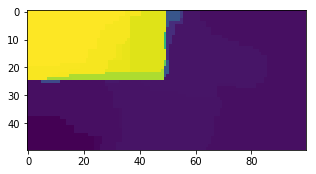

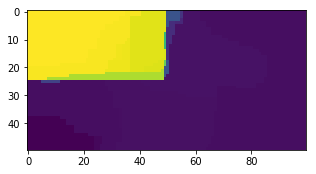

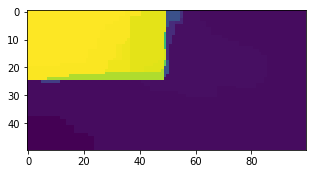

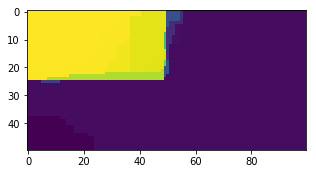

In [46]:
# The learnable parameters.
# First, we will fix the column and row-weights to be equal.
# We parametrize the log of these weights.
log_w_row = Variable(- 3 * torch.ones(1), requires_grad=True)
log_w_col = Variable(- 3 * torch.ones(1), requires_grad=True)
# We also have a scale weight.
scale = Variable(- torch.ones(1), requires_grad=True)

optimizer = torch.optim.SGD([log_w_row, log_w_col, scale], lr=.5)
# We keep data of the form (w_row, w_col, scale) at each iteration.
data = []
for iter_no in tqdm(range(1000)):
    w_row = torch.exp(log_w_row)
    w_col = torch.exp(log_w_col)
    y = tv2d()(scale * x_noisy, w_row.expand((m, n-1)), w_col.expand((m - 1, n)))
    optimizer.zero_grad()
    loss = torch.mean((y - x)**2)
    loss.backward()
    if iter_no % 100 == 0:
        losses.append(loss.data[0])
        plot(y.data)
    data.append((w_row.data[0], w_col.data[0], scale.data[0]))
    optimizer.step()

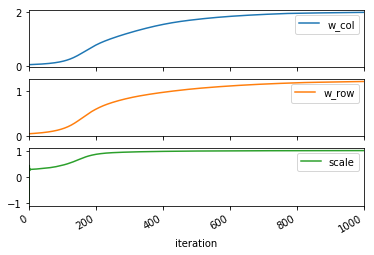

In [55]:
df = DataFrame(data, columns=('w_col', 'w_row', 'scale'))
axes = df.plot(subplots=True)
axes[-1].set_xlabel('iteration');